In [1]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

## 데이터 불러오기

In [2]:
# 필요한 컬럼들 불러와서 데이터프레임으로 만들어주기
rating_file_path = os.getcwd() + '/data/ml-1m/ratings.dat'
ratings_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(rating_file_path,sep='::',names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 평점 3점 이상만 가져오기

In [3]:
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size:{orginal_data_size}, filtered_data_size:{filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size/orginal_data_size:.2%}')

orginal_data_size:1000209, filtered_data_size:836478
Ratio of Remaining Data is 83.63%


### rating column 이름을 count로 바꾼다.
__우리는 평점을 시청횟수로 간주할꺼니까!__

In [4]:
ratings.rename(columns={'rating':'count'}, inplace = True)

In [5]:
ratings.head()

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
# timestamp feature 버리기
ratings = ratings.drop(columns = 'timestamp')

In [7]:
ratings.head()

,user_id,movie_id,count
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## 영화 제목을 보기 위해 메타 데이터를 읽어온다.

In [8]:
# movie_id와 title를 연결하기 위해 moives 데이터를 불러온다.
movie_file_path = os.getcwd() + '/data/ml-1m/movies.dat'
cols = ['movie_id','title','genre']
movies = pd.read_csv(movie_file_path,sep='::',names=cols,engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# string, 소문자로 바꿔준다.
movies['title'] = movies['title'].str.lower()
movies = movies.drop(columns='genre')
movies.tail(10)

,movie_id,title
3873,3943,bamboozled (2000)
3874,3944,bootmen (2000)
3875,3945,digimon: the movie (2000)
3876,3946,get carter (2000)
3877,3947,get carter (1971)
3878,3948,meet the parents (2000)
3879,3949,requiem for a dream (2000)
3880,3950,tigerland (2000)
3881,3951,two family house (2000)
3882,3952,"contender, the (2000)"


## 분석해보자
- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

__가장 인기 있는 영화 30개 뽑기__

In [10]:
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

__유저별 몇 개의 영화를 보았는지에 대한 통계__  
약 600편 이상의 영화를 본 사람은 거의 없다.(6039 중 145명)   
이 유저들은 제거한다.

In [11]:
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

<AxesSubplot:ylabel='Density'>

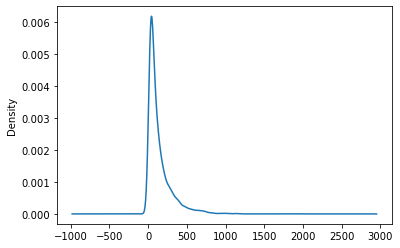

In [12]:
user_count.plot.kde()

In [13]:
print(f"전체 유저 수 : {len(user_count)} \n500편 이상 시청한 유저 수 : {len(user_count[user_count.values >= 600])}")

전체 유저 수 : 6039 
500편 이상 시청한 유저 수 : 145


In [14]:
too_much_user = list(user_count[user_count.values >= 600].index)

In [15]:
ratings.drop(ratings[ratings["user_id"].map(lambda x : x in too_much_user)].index, inplace=True)

__유저별 영화 시청 횟수(3~5) 중앙값에 대한 통계__

In [16]:
user_median = ratings.groupby('user_id')['count'].median()
user_median.describe()

count    5894.00000
mean        4.06074
std         0.43180
min         3.00000
25%         4.00000
50%         4.00000
75%         4.00000
max         5.00000
Name: count, dtype: float64

## 내가 선호하는 영화를 5가지 골라서 rating에 추가해주자

### indexing하기
moives 데이터프레임의 movie_id를 ratings의 movie_id에 인덱싱 해준다.  
메타데이터와 rating 데이터에 공통으로 있는 movie_id로 두 데이터프레임을 머지해주고  
title을 다시 인덱싱해준다.

In [17]:
# moive_id column을 기준으로 위에서 불러왔던 두 데이터프레임을 이어준다.
data = pd.merge(ratings, movies, how='left', on='movie_id')

In [18]:
# 내 정보(id, 시청한 영화, 영화별 횟수)
my_favorite = ['big (1988)', 'ben-hur (1959)', 'wizard of oz, the (1939)', 'last temptation of christ, the (1988)','apollo 13 (1995)']
my_movielist = pd.DataFrame({'user_id':['yoon']*5,'title':my_favorite, 'count':[5,4,5,3,4]})

if not data.isin({'user_id':['yoon']})['user_id'].any():
    data = data.append(my_movielist)

data.tail(10)

,user_id,movie_id,count,title
724245,6040,1090.0,3,platoon (1986)
724246,6040,1094.0,5,"crying game, the (1992)"
724247,6040,562.0,5,welcome to the dollhouse (1995)
724248,6040,1096.0,4,sophie's choice (1982)
724249,6040,1097.0,4,e.t. the extra-terrestrial (1982)
0,yoon,NaN,5,big (1988)
1,yoon,NaN,4,ben-hur (1959)
2,yoon,NaN,5,"wizard of oz, the (1939)"
3,yoon,NaN,3,"last temptation of christ, the (1988)"
4,yoon,NaN,4,apollo 13 (1995)


In [20]:
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [21]:
data.nunique()

user_id     5895
movie_id    3593
count          3
title       3593
dtype: int64

In [22]:
data.tail()

,user_id,movie_id,count,title
0,yoon,NaN,5,big (1988)
1,yoon,NaN,4,ben-hur (1959)
2,yoon,NaN,5,"wizard of oz, the (1939)"
3,yoon,NaN,3,"last temptation of christ, the (1988)"
4,yoon,NaN,4,apollo 13 (1995)


In [23]:
# user_id를 새로 indexting
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):
    print('user_id colunm indexing OK')
    data['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail!')

# title을 새로 indexing
temp_title_data = data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(data):
    print('title column indexing OK!')
    data['title'] = temp_title_data
else:
    print('title column indexing Fail')

data

user_id colunm indexing OK
title column indexing OK!


,user_id,movie_id,count,title
0,0,1193.0,5,0
1,0,661.0,3,1
2,0,914.0,3,2
3,0,3408.0,4,3
4,0,2355.0,5,4
...,...,...,...,...
0,5894,NaN,5,19
1,5894,NaN,4,6
2,5894,NaN,5,9
3,5894,NaN,3,2408


## CSR Matrix 를 직접 만들어 보자

In [24]:
num_user = data['user_id'].nunique()
num_title = data['title'].nunique()

csr_data = csr_matrix((data['count'], (data.user_id, data.title)), 
                      shape=(num_user, num_title))
csr_data
csr_data_transpose = csr_data.T

## als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜보자

In [25]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [26]:
als_model = AlternatingLeastSquares(factors=200, regularization=0.01,
                                   use_gpu=False, iterations=35,
                                   dtype=np.float32)

In [27]:
als_model.fit(csr_data_transpose)

  0%|          | 0/35 [00:00<?, ?it/s]

## 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보자.
  
  
내가 좋아하는 영화  
- 'big (1988)'
- 'ben-hur (1959)'
- 'wizard of oz, the (1939)'
- 'last temptation of christ, the (1988)'
- 'apollo 13 (1995)'

In [28]:
yoon, ben_hur = user_to_idx['yoon'], title_to_idx['ben-hur (1959)']
big = title_to_idx['big (1988)']
oz = title_to_idx['wizard of oz, the (1939)']
last = title_to_idx['last temptation of christ, the (1988)']
aplollo = title_to_idx['apollo 13 (1995)']

yoon_vector, ben_hur_vector = als_model.user_factors[yoon], als_model.item_factors[ben_hur]
big_vector = als_model.item_factors[big]
oz_vector =als_model.item_factors[oz]
last_vector =als_model.item_factors[last]
aplollo_vector =als_model.item_factors[aplollo]

In [29]:
def vector_dot(uvector, movie_vectors):
    for mov in movie_vectors:
        print(np.dot(uvector, mov))

In [30]:
#인덱스를 다시 영화 제목으로 바꿔주는 함수
idx_to_title = {v:k for k,v in title_to_idx.items()}
def get_similar_movie(movie_title: str):
    movie_id = title_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [31]:
movie_vectors=[big_vector, ben_hur_vector, oz_vector, last_vector, aplollo_vector]
vector_dot(yoon_vector, movie_vectors)

0.5271177
0.46460614
0.650082
0.10674511
0.56713057


내가 가장 선호하는 영화는 벡터곱 결과 0.63으로 wizard of oz, the (1939)

In [32]:
#본적 없는 영화 toy story (1995)
toy_story = title_to_idx['toy story (1995)']
toy_story_vector = als_model.item_factors[toy_story]
np.dot(yoon_vector, toy_story_vector)

-0.01168976

## 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [33]:
#내가 좋아하는 영화 목록에 있던 오즈의 마법사와 유사한 영화를 뽑아보면
#초콜릿 공장이 바로 다음 목록으로 나오는 것을 확인할 수 있다.
get_similar_movie('wizard of oz, the (1939)')

['wizard of oz, the (1939)',
 'willy wonka and the chocolate factory (1971)',
 'treasure of the sierra madre, the (1948)',
 "singin' in the rain (1952)",
 'man who would be king, the (1975)',
 'kaspar hauser (1993)',
 'fantasia (1940)',
 'to kill a mockingbird (1962)',
 'mary poppins (1964)',
 'snow white and the seven dwarfs (1937)']

## 내가 가장 좋아할 만한 영화들을 추천받아 보자
내가 선호할 것 같은 영화 10개를 추천받고  
예상 선호도? 상관 정도를 출력시킨다.

In [34]:
similar_movies = als_model.recommend(yoon, csr_data, N=10, filter_already_liked_items=True)
similar_movies

[(678, 0.2803718),
 (365, 0.25092918),
 (26, 0.24849778),
 (582, 0.23710054),
 (527, 0.21454386),
 (655, 0.20962265),
 (248, 0.17459032),
 (501, 0.16891076),
 (980, 0.16538993),
 (133, 0.16435856)]

In [35]:
#인덱스 값을 영화제목으로 다시 바꿔준다.
[idx_to_title[i[0]] for i in similar_movies]

['willy wonka and the chocolate factory (1971)',
 'splash (1984)',
 'e.t. the extra-terrestrial (1982)',
 'beetlejuice (1988)',
 'batman (1989)',
 'lawrence of arabia (1962)',
 'good will hunting (1997)',
 'treasure of the sierra madre, the (1948)',
 'seven samurai (the magnificent seven) (shichinin no samurai) (1954)',
 'ed wood (1994)']

### 가장 선호도가 높았던 세 영화에 대해서 알아보자  
1. willy wonka and the chocolate factory (1971) : 0.280  
2. splash (1984)                       : 0.250  
3. e.t. the extra-terrestrial (1982)            : 0.248

In [38]:
willy = title_to_idx['willy wonka and the chocolate factory (1971)']
explain = als_model.explain(yoon, csr_data, itemid=willy)
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('wizard of oz, the (1939)', 0.15637517312221166),
 ('big (1988)', 0.15133108287737296),
 ('last temptation of christ, the (1988)', 0.02132120989055691),
 ('ben-hur (1959)', 0.010636401907243104),
 ('apollo 13 (1995)', -0.06091638381898466)]

In [41]:
beetle = title_to_idx['splash (1984)']
explain = als_model.explain(yoon, csr_data, itemid=beetle)
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('big (1988)', 0.23463264910464365),
 ('apollo 13 (1995)', 0.02342154607207514),
 ('wizard of oz, the (1939)', 0.008276938006637638),
 ('ben-hur (1959)', 0.0034498771171196877),
 ('last temptation of christ, the (1988)', -0.021381378211630914)]

In [39]:
et = title_to_idx['e.t. the extra-terrestrial (1982)']
explain = als_model.explain(yoon, csr_data, itemid=et)
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('big (1988)', 0.1592764997737252),
 ('wizard of oz, the (1939)', 0.09281065504878061),
 ('apollo 13 (1995)', 0.034964483864526524),
 ('ben-hur (1959)', -0.01738314413582697),
 ('last temptation of christ, the (1988)', -0.022092258563648354)]